In [1]:
# Import required packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime, timedelta
import time
import rasterio as rio
import xarray as xr
import rioxarray
import isce
import logging
root_logger = logging.getLogger()
root_logger.setLevel('WARNING')
import logging
from imageMath import IML
import isce
from components.contrib.geo_autoRIFT.autoRIFT import autoRIFT_ISCE
from components.contrib.geo_autoRIFT.autoRIFT import __version__ as version
import isceobj
import subprocess
import re
import cv2

In [2]:
os.environ['AUTORIFT'] = '/mnt/Backups/gbrench/sw/insar_tools/isce2/src/isce2/contrib/geo_autoRIFT'
os.environ['PYTHONPATH'] = os.environ['AUTORIFT']
os.environ['PATH'] += f":{os.environ['AUTORIFT']}"

In [3]:
scene_list=[
'S1A_IW_SLC__1SDV_20191004T121345_20191004T121412_029309_0354B0_F48E',
'S1A_IW_SLC__1SDV_20191016T121345_20191016T121412_029484_035ABB_373F',
'S1A_IW_SLC__1SDV_20191028T121345_20191028T121412_029659_0360C3_574E',
'S1A_IW_SLC__1SDV_20191109T121345_20191109T121412_029834_0366F3_462C',
'S1A_IW_SLC__1SDV_20191121T121344_20191121T121411_030009_036CFD_787C',
'S1A_IW_SLC__1SDV_20191203T121344_20191203T121411_030184_03730F_4C1A',
'S1A_IW_SLC__1SDV_20191215T121344_20191215T121411_030359_03791A_4B57',
'S1A_IW_SLC__1SDV_20191227T121343_20191227T121410_030534_037F23_3C47',
'S1A_IW_SLC__1SDV_20200108T121343_20200108T121410_030709_038533_C53D',
'S1A_IW_SLC__1SDV_20200120T121342_20200120T121409_030884_038B59_8828',
'S1A_IW_SLC__1SDV_20200201T121342_20200201T121409_031059_039174_1908',
'S1A_IW_SLC__1SDV_20200213T121341_20200213T121408_031234_039785_41EB',
'S1A_IW_SLC__1SDV_20200225T121341_20200225T121408_031409_039D91_8F87',
'S1A_IW_SLC__1SDV_20200308T121341_20200308T121408_031584_03A39B_6624',
'S1A_IW_SLC__1SDV_20200320T121342_20200320T121409_031759_03A9BC_08F7',
'S1A_IW_SLC__1SDV_20200401T121342_20200401T121409_031934_03AFE6_E721',
'S1A_IW_SLC__1SDV_20200413T121342_20200413T121409_032109_03B610_2EA6',
'S1A_IW_SLC__1SDV_20200425T121343_20200425T121410_032284_03BC35_898C'
           ]

In [4]:
proc_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12'

In [5]:
def select_pairs(scene_list, min_temp_bline, max_temp_bline):
    scene_dates = {}
    for scene in scene_list:
        date = scene[17:25]
        scene_dates[date] = scene

    pairs = []
    for date1 in scene_dates:
        for date2 in scene_dates:
            if datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=max_temp_bline) and not datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=min_temp_bline) and not date1 >= date2 :
                pairs.append([date1, date2])
    
    print(f'number of pairs: {len(pairs)}')
    
    return pairs

In [6]:
pairs = select_pairs(scene_list, 80, 360)

number of pairs: 66


In [93]:
def run_autoRIFT(pair, skip_x=31, skip_y=5, preproc_filter_width=21, mpflag=1):

    print(f'opening pair: {pair[0]}-{pair[1]}')

    reference_fn = f'{proc_path}/work/merged/SLC/{pair[0]}/{pair[0]}.slc.full'
    secondary_fn = f'{proc_path}/work/merged/SLC/{pair[1]}/{pair[1]}.slc.full'

    ds1 = gdal.Open(reference_fn, gdal.GA_ReadOnly)
    slc1 = ds1.GetRasterBand(1).ReadAsArray()

    ds2 = gdal.Open(secondary_fn, gdal.GA_ReadOnly)
    slc2 = ds2.GetRasterBand(1).ReadAsArray()

    I1 = np.abs(slc1)
    I2 = np.abs(slc2)

    obj = autoRIFT_ISCE()
    obj.configure()
    obj.MultiThread = mpflag

    obj.WallisFilterWidth = preproc_filter_width

    obj.I1 = I1
    obj.I2 = I2

    obj.SkipSampleX = skip_x
    obj.SkipSampleY = skip_y

    # Kernel sizes to use for correlation
    obj.ChipSizeMinX = 32
    obj.ChipSizeMaxX = 64

    # check and refine this
    obj.ChipSize0X = 32

    # generate grid
    m,n = obj.I1.shape
    xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
    yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY)
    nd = xGrid.__len__()
    md = yGrid.__len__()
    obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
    obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
    noDataMask = np.logical_not(obj.xGrid)

    # populate nodata mask
    for ii in range(obj.xGrid.shape[0]):
        for jj in range(obj.xGrid.shape[1]):
            if (obj.yGrid[ii,jj] != None)&(obj.xGrid[ii,jj] != None):
                if (I1[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0)|(I2[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0):
                    noDataMask[ii,jj] = True

    # set search limit and offsets in nodata areas
    obj.SearchLimitX = obj.SearchLimitX * np.logical_not(noDataMask)
    obj.SearchLimitY = obj.SearchLimitY * np.logical_not(noDataMask)
    obj.Dx0 = obj.Dx0 * np.logical_not(noDataMask)
    obj.Dy0 = obj.Dy0 * np.logical_not(noDataMask)

    # replace the nodata value with zero
    obj.xGrid[noDataMask] = 0
    obj.yGrid[noDataMask] = 0
    obj.Dx0[noDataMask] = 0
    obj.Dy0[noDataMask] = 0

    # convert azimuth offset to vertical offset as used in autoRIFT convention
    obj.Dy0 = -1 * obj.Dy0

    print("preprocessing")
    obj.preprocess_filt_hps()
    obj.uniform_data_type()

    obj.OverSampleRatio = 64

    print("starting autoRIFT")
    obj.runAutorift()
    print("autoRIFT complete")

    kernel = np.ones((3,3),np.uint8)
    noDataMask = cv2.dilate(noDataMask.astype(np.uint8),kernel,iterations = 1)
    noDataMask = noDataMask.astype(np.bool_)

    return obj.Dx, obj.Dy #, obj.InterpMask, obj.ChipSizeX, obj.GridSpacingX, obj.ScaleChipSizeY, obj.SearchLimitX, obj.SearchLimitY, obj.origSize, noDataMask

In [97]:
pairs

[['20191004', '20191227'],
 ['20191004', '20200108'],
 ['20191004', '20200120'],
 ['20191004', '20200201'],
 ['20191004', '20200213'],
 ['20191004', '20200225'],
 ['20191004', '20200308'],
 ['20191004', '20200320'],
 ['20191004', '20200401'],
 ['20191004', '20200413'],
 ['20191004', '20200425'],
 ['20191016', '20200108'],
 ['20191016', '20200120'],
 ['20191016', '20200201'],
 ['20191016', '20200213'],
 ['20191016', '20200225'],
 ['20191016', '20200308'],
 ['20191016', '20200320'],
 ['20191016', '20200401'],
 ['20191016', '20200413'],
 ['20191016', '20200425'],
 ['20191028', '20200120'],
 ['20191028', '20200201'],
 ['20191028', '20200213'],
 ['20191028', '20200225'],
 ['20191028', '20200308'],
 ['20191028', '20200320'],
 ['20191028', '20200401'],
 ['20191028', '20200413'],
 ['20191028', '20200425'],
 ['20191109', '20200201'],
 ['20191109', '20200213'],
 ['20191109', '20200225'],
 ['20191109', '20200308'],
 ['20191109', '20200320'],
 ['20191109', '20200401'],
 ['20191109', '20200413'],
 

In [95]:
dx, dy = run_autoRIFT(pairs[9], mpflag=10, skip_x=31, skip_y=5)

opening pair: 20191004-20200413
preprocessing
starting autoRIFT
autoRIFT complete


In [20]:
dem_fn = f'{proc_path}/work/merged/geom_reference/hgt.rdr.full'
dem_ds = gdal.Open(dem_fn, gdal.GA_ReadOnly)
dem = dem_ds.GetRasterBand(1).ReadAsArray()

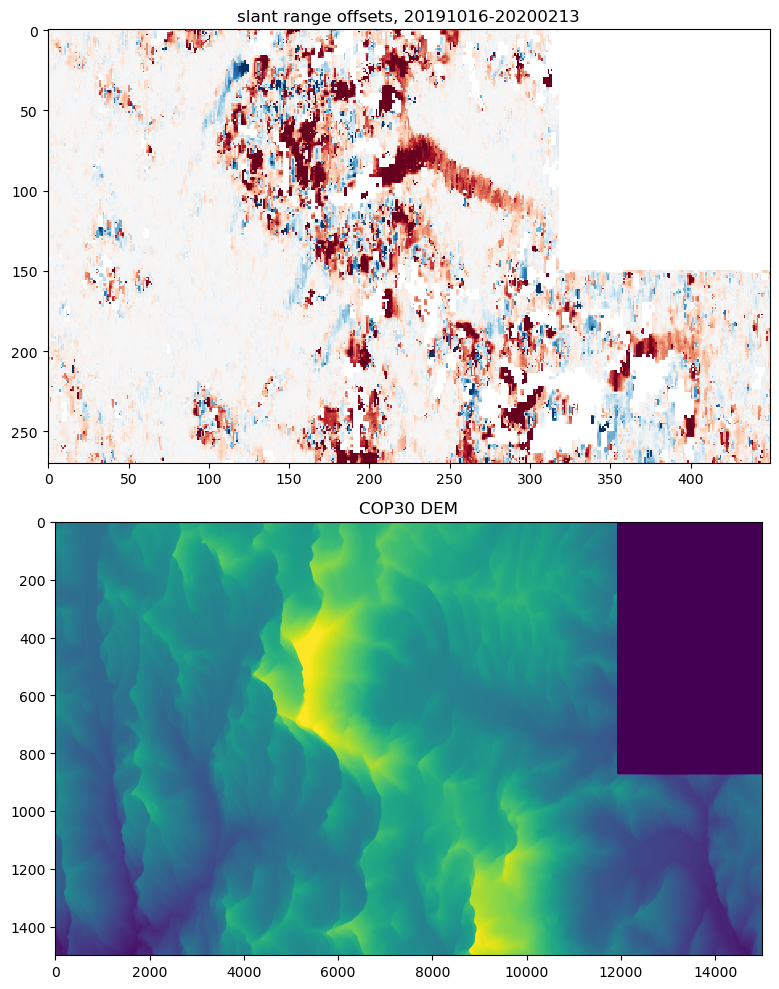

In [96]:
f, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].imshow(np.flip(dx, (0))[30:300, 350:800], cmap='RdBu_r', vmin=-4, vmax=4, interpolation='none')
ax[0].set_title(f'slant range offsets, {pairs[14][0]}-{pairs[14][1]}')
ax[0].set_aspect(1)

ax[1].imshow(np.flip(dem, (0))[0:1500, 10000:25000], vmin=3000, vmax=8000)
ax[1].set_title(f'COP30 DEM')
ax[1].set_aspect(6.13)

f.tight_layout()